In [1]:
import numpy as np
import math
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
%matplotlib inline
plt.style.use('seaborn-whitegrid')
mpl.style.use('seaborn')
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
import Abatement_functions as func

# Abatement Project: Adding end-of-pipe technologies to a CGE

Consider the simple setup:
* A sector uses inputs $(x,y)$ in production of a commodity/service $H$. 
* In using the input $x$ there is an associated emission of something 'bad'. Let $e^0$ denote emissions prior to abatement and $e$ actual emissions.
* There is a pre-abatement known emission coefficient in the use of $x$. Denote this $\eta$. Thus we have the simple relation:
    $$\begin{align}
    e^0 = \eta x^0,
    \end{align}$$
    where $x^0$ is the use of the input $x$, in absence of any regulation on emissions.
* Emissions are taxed at a rate $\tau$.

In general we think of three abatement channels:

* **Output reduction**: Given input-mix and abatement technology, a lower output lowers the use of the dirty input $x$ and thus emissions.
* **Input substitution**: Given the output level and abatement technology, input can be mixed with lower use of $x$ (consequently more use of $y$ here), emissions can be lowered.
* **Abatement technology**: Given the output level and input-mix, targeted abatement equipment can lower emissions directly at some cost. 

We can further think of **abatement technology** in two different ways:

* **End-of-pipe abatement:** Lowers emissions without altering the optimal input-mix (think of a filter on an engine that burns fossil fuels).
* **Input-displacing abatement technology:** A discrete change in technology that alters the production function altogether (i.e. altering a production process).

In the following we will refer to *abatement technology* as an *end-of-pipe* type of technology, as the *input-displacing* type would involve a discrete choice between different production functions, which presents more of a challenge.

## 1: Abatement as discrete set of end-of-pipe technologies

### 1.1: Representing technology data

We assume that a technology dataset gives $T$ ways of abating emissions. Each technology $t$ is summed up by the information:
* $q_t \in [0,1]$ is the share of emissions that are abated, if the equipment is installed.
* $c_t\in R_+$ is unit cost of abating emissions. 

This gives rise to the optimal abatement $(A)$ as a function of the tax rate $(\tau)$, as well as the total abatement costs $(C)$:

$$\begin{align}
    A(\tau) &= \eta x \sum_{t=1}^{T} q_t * \mathbf{1}_{c_t<\tau}, && \mathbf{1}_{c_t<\tau} = \left\lbrace \begin{array}{ll} 0, & c_t\geq \tau \\ 1, & c_t<\tau \end{array} \right.  \tag{D1}\\ 
    C(\tau) &= \eta x \sum_{t=1}^{T} q_t c_t * \mathbf{1}_{c_t<\tau} \tag{D2}
\end{align}$$

**Draw and plot a data set for technologies:**

In [2]:
T = 10; # Number of technologies
abate_upper = 0.9 # Upper limit of total abatement (in percentages)
c_upper = 1 # Most expensive abatement technology
seed=21 # Set seed so the random draw does not change every time we run this cell.
labels = ['Tax on emissions', 'Abatement'] # Names on axes in plot below.
sample_c, sample_q_sum, sample_q = func.draw_sample(T,abate_upper,c_upper,seed) # draw samples of unit costs and abatement potential.

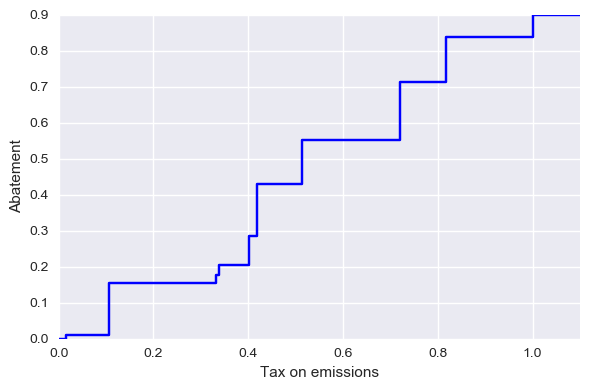

In [3]:
func.plot_stepcurve(sample_c,sample_q_sum,labels) # Plot abatement function.

### 1.2: Smoothing out the step-function

In an older version we told a story about how this step function looks like, if instead of constant unit costs of abatement $c_t$, there were a continuum of heterogeneous firms applying the abatement technologies. Either through difference in abilities or compatibility with the technology, we can think of the heterogeneity resulting in varying unit costs $c_t^i$ for each $i$ firm in the continuum. Alternatively we can think of it as a *smoothing device*, facilitating the use of gradient-based solvers.

The idea is to replace the abatement and cost functions with a smoothed stepwise curve of the form:

$$\begin{align}
    A_t(\tau) &= \eta x q_t \int_{\underline{s}}^{\tau} dF(c_t^i), \tag{S1} \\ 
              &= \eta x q_t F_t(\tau) \\
    C_t(\tau) &= \eta x q_t \int_{\underline{s}}^{\tau} c_t^i dF(c_t^i), \tag{S2} \\ 
              &= \eta x q_t F_t(\tau) \mathbb{E}\left[c_t^i|c_t^i<\tau\right]. 
\end{align}$$

where $F(\cdot)$ represents some continuously differentiable distribution with support on $[\underline{s},\bar{s}]$ (bounded support is not a necessary condition). Relevant functions that approximate the step-shape well are the *normal* and *log-normal* distributions.

In the following we use the log-normal distribution in which case the functions are given by:

$$\begin{align}
    ln(c_t^i) &\sim N\left(ln(c_t)-\dfrac{\sigma^2}{2},\mbox{ }\sigma^2\right) \tag{S3} \\ 
    A_t(\tau) &= \eta x q_t \underbrace{\Phi\left(\dfrac{ln(\tau)-ln(c_t)+\sigma^2/2}{\sigma}\right)}_{F_t^q(\tau)} \tag{S4} \\ 
    C_t(\tau) &= \eta x q_t c_t \underbrace{\Phi\left(\dfrac{ln(\tau)-ln(c_t)-\sigma^2/2}{\sigma}\right)}_{F_t^c(\tau)} \tag{S5}
\end{align}$$

(Alternatively we could use the normal distribution. This has some nice properties when it comes to the $A_t(\tau)$ function, but is a more complicated function for $C_t(\tau)$. There are several other readily available smoothing functions out there though.)

**Plot the smoothed function varying $\sigma$**

In [4]:
n_tau_grid = 500
n_sigma_grid = 100;
sigma_grid = np.linspace(0.0001,0.25,n_sigma_grid)
tau_grid = np.linspace(0.01,c_upper*1.1,n_tau_grid)
A_share, C_share = func.smooth_sample(sample_c,tau_grid,sigma_grid)

In [5]:
A = np.sum((A_share * sample_q[:,None,None]), axis=0) 
func.interactive_sigma(A,tau_grid,sigma_grid,int((n_sigma_grid/2)),'Abatement')

interactive(children=(FloatSlider(value=0.1263121212121212, description='$\\sigma$', max=0.25, min=0.0001, ste…

Note that with a log-normal distribution, the $\sigma$ values should not be constant across technologies, as there is a clear skewness in the smoothing (more smooth for larger $\tau$).

## 2: Application in the world's simplest CGE model

### 2.1: The Setup: 

In a shocking twist of events we learn that the production function of the polluting firm is of the CES type. With abatement technology and cost functions as discussed above, the profit maximization problem that the firm is facing is given by:

$$\begin{align}
    \max_{x,y,H}\mbox{ }\Pi = pH - \tau e -C-p_xx-p_yy, \tag{CES-1}
\end{align}$$

subject to the constraints:

$$\begin{align}
 H =& \left(\mu_x^{1/\theta}x^{\frac{\theta-1}{\theta}}+\mu_y^{1/\theta}y^{\frac{\theta-1}{\theta}}\right)^{\frac{\theta}{\theta-1}} \tag{CES-2} \\ 
 e =& \eta x \left(1-\sum_{t=1}^T q_tF_t^q(\tau) \right) \tag{CES-3} \\ 
 C =& \eta x \sum_{t=1}^T q_tc_tF_t^c(\tau) \tag{CES-4}
\end{align}$$

The resulting first order conditions for optimality are then given by:

$$\begin{align}
    x &= \mu_x H \left(\dfrac{p}{\hat{p}_x}\right)^{\theta} \tag{CES-5} \\ 
    y &= \mu_y H \left(\dfrac{p}{p_y}\right)^{\theta} \tag{CES_6} \\
    \hat{p}_x &= p_x+\eta\left(\tau-\sum_{t=1}^Tq_t\Big[\tau F_t^q(\tau)-c_tF_t^c(\tau)\Big]\right) \tag{CES-7}
\end{align} $$

along with (CES-2)-(CES-4).

### 2.2: Emission taxes increases adjusted relative price of applying dirty input

The additional effects on the relevant price on the use of the dirty input $x$ is now:
1. Emission tax on marginal pollution of size $\eta \tau$.
2. A gain (relative to paying the full tax on all emissions), from applying profitable abatement equipment:

$$\begin{align}
    \text{Abatement gain } = \eta \sum_{t=1}^Tq_t\Big[\tau F_t^q(\tau)-c_t F_t^c(\tau)\Big]\geq 0.
\end{align}$$ 
The inequality comes from the fact that

$$\begin{align}
    c_tF_t^c(\tau) = \mathbb{E}\left[c_t|c_t<\tau\right] F_t^q(\tau), 
\end{align}$$

which per construction is lower than $\tau F_t^q(\tau)$. However, it is also straightforward to see that the higher the tax $\tau$, the higher is the 'adjusted' price on the dirty input:

$$\begin{align}
    \hat{p}_x \geq p_x, && \text{as } && \tau \geq \sum_{t=1}^T q_t\Big[\tau F_t^q(\tau)-c_tF_t^c(\tau)\Big].
\end{align}$$

This follows from the fact that:

$$\begin{align}
    \sum_t^T q_t \leq& 1
\end{align}$$

and 

$$\begin{align}
   0\leq  \tau F_t^q(\tau)-c_tF_t^c(\tau) = F_t^q(\tau)\left(\tau-\mathbb{E}\left[c_t|c_t<\tau\right]\right) \leq \tau.
\end{align}$$



### 2.3: The abatement gain is fully crowded out by adjusted output prices, i.e. there are still zero profits with perfect competition

Evaluating the profit function in (CES-1), substituting initially for (CES-5) and (CES-6) yields:

$$\begin{align}
    \Pi^*   &= pH-\tau e-C-\mu_x H p^{\theta} \dfrac{p_x}{(\hat{p}_x)^{\theta}}-\mu_y H p^{\theta}p_y^{1-\theta} \\ 
            &= H\left[p-p^{\theta}\left(\mu_x \dfrac{p_x}{\left(\hat{p}_x\right)^{\theta}}+\mu_yp_y^{1-\theta}\right)\right]-\tau e- C
\end{align}$$ 

Focus on the last part concerning emissions. Substitute for (CES-3)-(CES-4) (abatement functions) to get:

$$\begin{align}
    \tau e + C &= \tau \eta x \left(1-\sum_{t=1}^T q_tF_t^q (\tau)\right)+\eta x \sum_{t=1}^T q_tc_tF_t^c(\tau). \\ 
                &= \eta x \left(\tau - \sum_{t=1}^T q_t \left[\tau F_t^q(\tau)-c_tF_t^c(\tau)\right]\right)
\end{align}$$

Using (CES-7) we can rewrite this as:

$$\begin{align}
    \tau e + C = x \left(\hat{p}_x-p_x\right).
\end{align}$$

Plugging this back into the expression for $\Pi^*$ we then have:

$$\begin{align}
    \Pi^* = H\left[p-p^{\theta}\left(\mu_x\dfrac{p_x}{(\hat{p}_x)^{\theta}}+\mu_yp_y^{1-\theta}\right)\right]-x\left(\hat{p}_x-p_x\right).
\end{align}$$

Finally substituting for $x$ using (CES-5) this yields the maximized profit function:

$$\begin{align}
    \Pi^* &= H\left[p-p^{\theta}\left(\mu_x\dfrac{p_x}{(\hat{p}_x)^{\theta}}+\mu_yp_y^{1-\theta}\right)\right]-\mu_x H \left(\dfrac{p}{\hat{p}_x}\right)^{\theta}\left(\hat{p}_x-p_x\right) \\ 
    & = H\left[p-p^{\theta}\left(\mu_x\left(\hat{p}_x\right)^{1-\theta}+\mu_y\left(p_y\right)^{1-\theta}\right)\right]
\end{align}$$



With the *usual* CES price index of (Combine production function with the (CES-5)-(CES-6) to show)

$$\begin{align}
    p = \left(\mu_x\left(\hat{p}_x\right)^{1-\theta}+\mu_y\left(p_y\right)^{1-\theta}\right)^{\frac{1}{1-\theta}},
\end{align}$$

this yields exactly zero profits $\Pi^* = 0$.

## 3: Further analysis and plots 

Here we investigate and plot a number of the functions derived above:

* The *abatement gain* function, 
* The *adjusted relative price on dirty good*, 
* Total emissions and abatement, (more interesting things?)

all as a function of the tax rate $\tau$, and with interactive features for parameters $(\mu_x,\theta,\sigma)$.

### 3.1: Abatement gain function

Start with settings:

In [6]:
# Fixed values: 
eta,px,py,muy = 2,5,4,1
# Grids:
n_tau_grid,n_sigma_grid,n_mux_grid,n_theta_grid = 100,10,6,6
tau_grid = np.linspace(0.01,c_upper*1.1,n_tau_grid)
sigma_grid = np.linspace(0.0001,0.25,n_sigma_grid)
mux_grid = np.linspace(0.5, 2.5,n_mux_grid)
theta_grid = np.linspace(0.25, 1.25, n_theta_grid)

Used already drawn abatement technology data set. Recall only $(\sigma)$ parameter enters the function. Note that the abatement gain function per construction is lower than $\tau$.

In [7]:
A_share, C_share = func.smooth_sample(sample_c,tau_grid,sigma_grid) # 3-dimensions: Technology (T), tau grid, sigma grid.
A = np.sum(( A_share * sample_q[:,None,None] * tau_grid[None,:,None]), axis=0)
C = np.sum(( C_share * sample_q[:,None,None] * sample_c[:,None,None]), axis=0)
Abatement_gain = eta*(A-C)
func.interactive_sigma(Abatement_gain,tau_grid,sigma_grid,int((n_sigma_grid/2)),'Abatement gain')

interactive(children=(FloatSlider(value=0.13893333333333333, description='$\\sigma$', max=0.25, min=0.0001, st…

### 3.2: The Relative price on the 'dirty' input factor 

Recall that the price was given by: 

$$\begin{align}
\hat{p}_x &= p_x+\eta\left(\tau-\sum_{t=1}^Tq_t\Big[\tau F_t^q(\tau)-c_tF_t^c(\tau)\Big]\right) = p_x + \eta \tau - \text{Abatement gain}
\end{align}$$


In [8]:
px_hat = px + eta * tau_grid[:,None]-Abatement_gain
func.interactive_sigma(px_hat,tau_grid,sigma_grid,int((n_sigma_grid/2)),'$\hat{p}_x$')

interactive(children=(FloatSlider(value=0.13893333333333333, description='$\\sigma$', max=0.25, min=0.0001, st…

### 3.3: Emissions and abatement